In [1]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display
import os
import inspect

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=False)

import scipy
import faiss
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.tools.nn_utils import get_faiss_index
from params import *
from utils import params_to_dataframe
from notebook_utils import get_model_name, get_arch, get_ds_name

fontsize=18

# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

# new

In [2]:
from lolip.models.torch_utils import archs

def get_dataset_info(dataset):
    if dataset not in dataset_infos:
        trnX, trny, tstX, _, ood = auto_var.get_var_with_argument("dataset", dataset)
        oodX = np.concatenate((ood[0], ood[1]), axis=0)
        
        index = get_faiss_index(int(np.prod(trnX.shape[1:])), 2)
        
        if ("calced" not in dataset) and ("aug10-imgnet" in dataset):
            from torchvision import transforms
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            def np_normalize(X):
                X = X.transpose(0, 3, 1, 2)
                return normalize(torch.from_numpy(X)).numpy().transpose(0, 2, 3, 1)
            index.add(np_normalize(trnX).astype(np.float32).reshape(len(trnX), -1))
            D, I = index.search(np_normalize(oodX).astype(np.float32).reshape(len(oodX), -1), k=1)
        else:
            index.add(trnX.astype(np.float32).reshape(len(trnX), -1))
            D, I = index.search(oodX.astype(np.float32).reshape(len(oodX), -1), k=1)
        D, I = D.reshape(-1), I.reshape(-1)
        D = np.sqrt(D)
        oody = trny[I]
        dataset_infos[dataset] = (trnX, trny, tstX, oodX, I, D, oody)
    return dataset_infos[dataset]

def get_preds(model, dset, batch_size=64, device="cuda", verbose=False):
    model.eval().to(device)
    if isinstance(dset, np.ndarray):
        if len(dset.shape) == 4:
            dset = dset.transpose(0, 3, 1, 2)
        dset = torch.utils.data.TensorDataset(
            #torch.from_numpy(dset).float(),
            torch.from_numpy(dset),
            torch.ones(len(dset))
        )

    loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, num_workers=24)
    
    ret = []
    for (x, _) in tqdm(loader, disable=(not verbose)):
        #x.requires_grad_(False)
        #output = F.softmax(model(x.to(device)).detach(), dim=1)
        with torch.no_grad():
            output = F.softmax(model(x.to(device)), dim=1)
        ret.append(output.cpu().numpy())
    del loader
    return np.concatenate(ret, axis=0)

In [13]:
results = {}

In [4]:
dataset_infos = {}

In [5]:
def plot_hist(adv_dists, ood_dists, figure_name, show=True, with_legend=True):
    ttt = np.log(adv_dists)
    if abs(ttt.max() - ttt.min()) < 0.1:
        y = [len(adv_dists)]
        x = [(ttt.max() - ttt.min()) / 2]
        matplotlib.pyplot.bar(x, y, width=0.1, color="#ff7f0e")
    else:
        bins = 20
        plt.hist(ttt, bins=bins, label="empirical robust radius")
    ttt = np.log(ood_dists)
    plt.hist(ttt, bins=20, label="OOD distance")
    

    plt.yticks(fontsize=fontsize)
    #plt.yticks([], [])
    plt.ylabel('counts', fontsize=fontsize)
    plt.xlabel('natural log $\ell_2$ distance', fontsize=fontsize)
    plt.xticks(fontsize=fontsize-2)
    if with_legend:
        plt.legend(fontsize=(fontsize-2))
    plt.tight_layout()
    
    plt.savefig(f"./figs/rob_histograms/{figure_name}")
    if show:
        plt.show()
    plt.close()

def get_rob_results(dataset, dname, method_name, model_path, result_path, ood_result_paths, arch, with_legend=True):
    res = joblib.load(result_path)
    trnX, trny, tstX, oodX, I, D, oody = get_dataset_info(dataset)
    n_classes = len(np.unique(trny))
    
    arch_fn = getattr(archs, arch)
    n_channels = 1 if ('mnist' in dataset) else 3
    arch_params = dict(n_classes=n_classes, n_channels=n_channels)
    if 'n_features' in inspect.getfullargspec(arch_fn)[0]:
        arch_params['n_features'] = (trnX.shape[1], )
    model = arch_fn(**arch_params).eval()
    model.load_state_dict(torch.load(model_path)['model_state_dict'])

    ood_pred = np.concatenate((res['oos_trn_pred'].reshape(-1), res['oos_tst_pred'].reshape(-1)))
    ncg_accs = (ood_pred == oody)

    for i, ood_robust_path in enumerate(ood_result_paths):
        if not os.path.exists(ood_robust_path):
            print(f"Missing {ood_robust_path}")
            continue
        try:
            rob_res = joblib.load(ood_robust_path)
        except:
            print(f"Missing {ood_robust_path}")
            continue
        trn_idx = rob_res['trn_idx']
        adv_trnX = rob_res['adv_trnX']
        
        if i == 0:
            n_samples = len(trn_idx)
            adv_dists = np.ones(n_samples) * np.inf
            failed_attack_ind = np.ones(n_samples)
            
        temp = np.linalg.norm((adv_trnX - trnX[trn_idx]).reshape(len(trn_idx), -1), ord=2, axis=1)
        preds = get_preds(model, trnX[trn_idx]).argmax(1)
        #if (preds != trny[trn_idx]).sum() != 0:
        #    import ipdb; ipdb.set_trace()
        assert (preds != trny[trn_idx]).sum() < 10, (preds == trny[trn_idx]).sum()
        # numarical errors could cause prediction to change after loading the saved model ....
        #failed_temp = np.logical_or((preds == trny[trn_idx]), temp == 0)
        
        if 'successes' in rob_res:
            failed_temp = np.logical_not(rob_res['successes'])
        elif 'adv_preds' in rob_res:
            preds = rob_res['adv_preds']
            failed_temp = (preds == trny[trn_idx])
        else:
            preds = get_preds(model, adv_trnX).argmax(1)
            failed_temp = (preds == trny[trn_idx])
        print(failed_temp.mean())
        
        adv_dists[np.logical_not(failed_temp)] = np.minimum(adv_dists[np.logical_not(failed_temp)], temp[np.logical_not(failed_temp)])
        failed_attack_ind = np.logical_and(failed_temp, failed_attack_ind)
            
    ood_dists = []
    ood_counts = []
    ood_within_counts = []
    ood_nn_idx = []
    within_list = []
    ncg_correctness = []
    first = True
    for k, i in enumerate(trn_idx):
        ind = np.where(I == i)[0]
        if failed_attack_ind[k] == 1:
            print("Rare")
            continue
        for j in ind:
            ood_dists.append(D[j] + 1e-5)
        if len(ind) > 0:
            ood_counts.append(len(ind))
            ood_within_counts.append((D[ind] < adv_dists[k]).sum())
            ood_nn_idx.append(ind)
            within_list.append((D[ind] < adv_dists[k]))
            ncg_correctness.append(trny[I[ind]] == ood_pred[ind])
        else:
            print("shouldn't happen")
            
    ood_nn_idx = np.concatenate(ood_nn_idx)
    within_list = np.concatenate(within_list)
    ncg_correctness = np.concatenate(ncg_correctness)
    in_rob_r_portion = np.sum(ood_within_counts) / np.sum(ood_counts)
    
    if with_legend:
        figure_name = f"{dname}_{method_name}.png"
    else:
        figure_name = f"{dname}_{method_name}_nolegend.png"
    plot_hist(adv_dists[~np.isinf(adv_dists)], ood_dists, figure_name, show=True, with_legend=with_legend)
    
    return adv_dists[~np.isinf(adv_dists)], ood_dists, in_rob_r_portion, ncg_accs.mean(), ood_nn_idx, within_list, ncg_correctness

('calcedrepr-mnistwo4', 'TRADES(4)')
0.0
1.0
1.0
1.0
0.0
0.0
0.63
0.96
1.0
0.04
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0


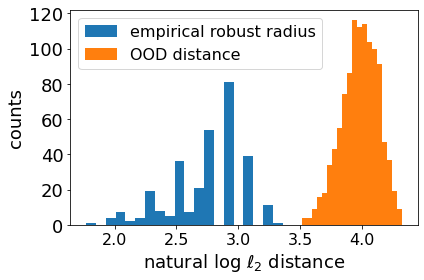

('calcedrepr-mnistwo4', 'TRADES(8)')
0.0
1.0
0.9966666666666667
1.0
0.0
0.006666666666666667
0.8333333333333334
0.99
0.9966666666666667
0.39666666666666667
0.99
0.99
0.99
1.0
1.0
0.99
0.0
0.0
0.99


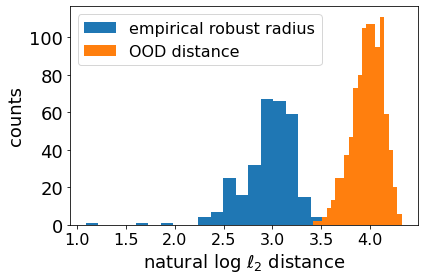

('calcedrepr-mnistwo9', 'TRADES(4)')
0.0
1.0
1.0
1.0
0.0
0.0
0.6133333333333333
0.9733333333333334
1.0
0.09333333333333334
1.0
1.0
1.0
1.0
1.0
0.9966666666666667
0.0
0.0
0.9966666666666667


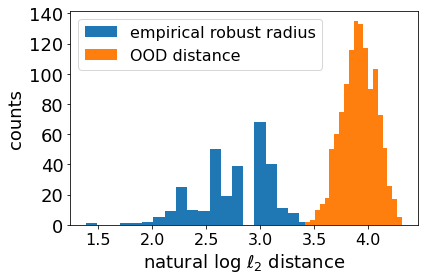

('calcedrepr-mnistwo9', 'TRADES(8)')
0.0
1.0
0.9966666666666667
1.0
0.0
0.016666666666666666
0.7666666666666667
0.9966666666666667
0.9966666666666667
0.39666666666666667
0.9966666666666667
0.9966666666666667
0.9966666666666667
1.0
1.0
0.99
0.0
0.0
0.99


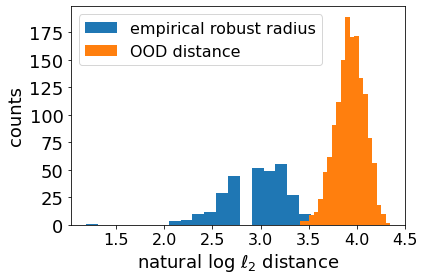

In [14]:
all_settings = []

method_names = [("natural", 'ce', 1.0), ("TRADES(2)", 'trades6ce', 2.0), ("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0), ("AT(1)", 'advce', 1.0)]

#for i in [0, 4, 9]:
#    for method_name, loss, eps in method_names:
#        arch = "LargeMLP"
#        all_settings.append(
#            dict(
#                dname = f"calcedrepr-cifar10wo{i}",
#                dataset = f"calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
#                model_path = f"../models/out_of_sample/pgd-128-calcedrepr-cifar10wo{i}-pgd-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0-ep0070.pt",
#                result_path = f"../results/out_of_sample/cwl2-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                ood_result_paths = [
#                    f"../results/ood_robustness_correct/signopt-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdl2_10000_1.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdlinf_10000_1.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000_8.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000_3.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000_2.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_25000_2.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_25000_1.5-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbl2bba-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdl2_10000_2.0-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdl2-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/cwl2-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/pgd_1000-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/mtv2-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/mtv2_50-128-calcedrepr-cifar10wo{i}-cwl2-64-cifar10wo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                ],
#                method_name = method_name,
#                arch = arch,
#            )
#        )
#        
##for i in [0, 4, 9]:
#for i in [9]:
#    for method_name, loss, eps in method_names:
#        arch = "LargeMLP"
#        all_settings.append(
#            dict(
#                dname = f"calcedrepr-cifar100coarsewo{i}",
#                dataset = f"calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl",
#                model_path = f"../models/out_of_sample/pgd-128-calcedrepr-cifar100coarsewo{i}-pgd-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0-ep0070.pt",
#                result_path = f"../results/out_of_sample/cwl2-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                ood_result_paths = [
#                    f"../results/ood_robustness_correct/signopt-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdl2_10000_1.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdlinf_10000_1.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000_8.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000_3.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000_2.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_50000-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_25000_2.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary_25000_1.5-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbboundary-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbl2bba-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdl2-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/fbpgdl2_10000_2.0-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/cwl2-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/pgd_1000-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/mtv2-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                    f"../results/ood_robustness_correct/mtv2_50-128-calcedrepr-cifar100coarsewo{i}-cwl2-64-cifar100coarsewo{i}-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
#                ],
#                method_name = method_name,
#                arch = arch,
#            )
#        )
#        
#method_names = [("natural", 'ce', 1.0), ("TRADES(2)", 'trades6ce', 2.0), ("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0), ("AT(.5)", 'advce', 0.5)]
method_names = [("AT(.5)", 'advce', 0.5)]
#for i in [0, 1, 2]:
for i in [0, ]:
    arch = "LargeMLPv4"
    for method_name, loss, eps in method_names:
        lr = 0.01 if method_name == "TRADES(2)" else 0.1
        all_settings.append(
            dict(
                dname = f"calcedrepr-aug10-imgnet100wo{i}",
                dataset = f"calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl",
                model_path = f"../models/out_of_sample/pgd-128-calcedrepr-aug10-imgnet100wo{i}-pgd-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0-ep0070.pt",
                result_path = f"../results/out_of_sample/cwl2-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                ood_result_paths = [
                    f"../results/ood_robustness_correct/cwl2-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/signopt-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary_25000_1.0-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary_50000-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/pgd_1000-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/mtv2_50-128-calcedrepr-aug10-imgnet100wo{i}-cwl2-128-aug10-imgnet100wo{i}-70-1.0-0.01-ce-vtor2-ResNet50Norm01-0.0-2-adam-0-0.0.pkl-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.9-2-sgd-0-0.0.pkl",
                ],
                method_name = method_name,
                arch = arch,
            )
        )
        
method_names = [("natural", 'ce', 1.0), ("TRADES(2)", 'trades6ce', 2.0), ("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0), ("AT(2)", 'advce', 2.0)]
method_names = [("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0)]
#for i in [0, 1, 4, 9]:
for i in [4, 9]:
    for method_name, loss, eps in method_names:
        all_settings.append(
            dict(
                dname = f"calcedrepr-mnistwo{i}",
                dataset = f"calcedreprold-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl",
                model_path = f"../models/out_of_sample/pgd-256-calcedrepr-mnistwo{i}-pgd-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0-ep0070.pt",
                result_path = f"../results/out_of_sample/cwl2-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                ood_result_paths = [
                    f"../results/ood_robustness_correct/cwl2-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/signoptrand-256-calcedreprold-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/signopt-256-calcedreprold-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/signopt-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2_10000_64.0-256-calcedreprold-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2_10000_32.0-256-calcedreprold-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary_50000_16.0-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary_50000_8.0-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary_50000_4.0-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdlinf_10000_1.0-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary_50000-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbboundary-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbl2bba-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2_10000_1.0-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2_10000_2.0-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/mtv2_50-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/mtv2-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                    f"../results/ood_robustness_correct/pgd_1000-256-calcedrepr-mnistwo{i}-cwl2-128-mnistwo{i}-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-{eps}-0.01-{loss}-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl",
                ],
                method_name = method_name,
                arch = "LargeMLP",
            )
        )

        
# fraction of time the label goes from cat to dog

for ent in all_settings:
    #dataset, dname, method_name, model_path, result_path, ood_robust_paths, arch = ent['dataset'], ent['dname'], ent['method_name'], ent['model_path'], ent['result_path'], ent['ood_robust_paths'], ent['arch']
    #adv_dists, ood_dists, in_rob_r_portion = get_rob_results(dataset, dname, method_name, model_path, result_path, ood_robust_paths, arch)
    key = (ent['dname'], ent['method_name'])
    print(key)
    if key not in results:
        adv_dists, ood_dists, in_rob_r_portion, ncg_acc, ood_nn_idx, within_list, ncg_correctness = get_rob_results(**ent)
        results[key] = [np.mean(adv_dists), np.mean(ood_dists), in_rob_r_portion, ncg_acc, ood_nn_idx, within_list, ncg_correctness]

In [15]:
data = {}
for k, v in results.items():
    ood_nn_idx, within_list, ncg_correctness = v[4], v[5], v[6]
    data[k] = [v[0], v[1], v[2], v[3], np.logical_and(within_list, ncg_correctness).mean()]

In [16]:
df = pd.DataFrame.from_dict(data, orient="index",
                            columns=["avg adv dist.", "avg OOD dist.", "XD", "ncg acc", "in radius portion"])
df = df.sort_index()
df.index = pd.MultiIndex.from_tuples(df.index)
df

avg adv dist.  avg OOD dist.   XD   ncg acc  \
calcedrepr-mnistwo4 TRADES(4)      16.436266      54.225028  0.0  0.814918   
                    TRADES(8)      20.389073      53.803331  0.0  0.859613   
calcedrepr-mnistwo9 TRADES(4)      16.430955      50.695964  0.0  0.741880   
                    TRADES(8)      20.465122      51.481997  0.0  0.798362   

                               in radius portion  
calcedrepr-mnistwo4 TRADES(4)                0.0  
                    TRADES(8)                0.0  
calcedrepr-mnistwo9 TRADES(4)                0.0  
                    TRADES(8)                0.0

In [17]:
text = df[["avg adv dist.", "avg OOD dist.", "in radius portion", "ncg acc",]].to_latex(float_format="%.2f", multirow=True)
text = text.replace("avg adv dist.", "empirical robust radius")
text = text.replace("avg OOD dist.", "OOD dist.")
text = text.replace("in radius portion", "percentage covered")
text = text.replace("ncg acc", "NCG acc.")
text = text.replace("calcedrepr-aug10-imgnet100wo", "I-")
text = text.replace("calcedrepr-cifar100coarsewo", "C100-")
text = text.replace("calcedrepr-cifar10wo", "C10-")
text = text.replace("calcedrepr-mnist", "M-")
print(text)

\begin{tabular}{llrrrr}
\toprule
                    &           &  empirical robust radius &  OOD dist. &  percentage covered &  NCG acc. \\
\midrule
\multirow{2}{*}{M-wo4} & TRADES(4) &          16.44 &          54.23 &               0.00 &     0.81 \\
                    & TRADES(8) &          20.39 &          53.80 &               0.00 &     0.86 \\
\cline{1-6}
\multirow{2}{*}{M-wo9} & TRADES(4) &          16.43 &          50.70 &               0.00 &     0.74 \\
                    & TRADES(8) &          20.47 &          51.48 &               0.00 &     0.80 \\
\bottomrule
\end{tabular}



In [86]:
dataset_infos['calcedrepr-cifar100coarsewo4-cwl2-64-cifar100coarsewo4-70-1.0-0.01-ce-vtor2-WRN_40_10-0.0-2-adam-0-0.0.pkl'][-3]

array([30979, 17950, 10570, ...,  6101, 28907,  9213])

In [131]:
i = 9
loss = "advce"
eps = "1.0"
arch = "LargeMLP"
path = f"../results/ood_robustness_correct/signopt-256-calcedrepr-mnistwo0-cwl2-128-mnistwo0-70-1.0-0.01-ce-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl-70-1.0-0.01-ce-vtor2-LargeMLP-0.9-2-sgd-0-0.0.pkl"
res = joblib.load(path)


## Pixel space

('aug10-imgnet100wo0', 'natural')
('aug10-imgnet100wo0', 'TRADES(2)')
('aug10-imgnet100wo0', 'TRADES(4)')
('aug10-imgnet100wo0', 'TRADES(8)')
('aug10-imgnet100wo0', 'AT(2)')
('aug10-imgnet100wo1', 'natural')
('aug10-imgnet100wo1', 'TRADES(2)')
('aug10-imgnet100wo1', 'TRADES(4)')
('aug10-imgnet100wo1', 'TRADES(8)')
('aug10-imgnet100wo1', 'AT(2)')
('aug10-imgnet100wo2', 'natural')
('aug10-imgnet100wo2', 'TRADES(2)')
('aug10-imgnet100wo2', 'TRADES(4)')
('aug10-imgnet100wo2', 'TRADES(8)')
('aug10-imgnet100wo2', 'AT(2)')
('mnistwo0', 'natural')
('mnistwo0', 'TRADES(2)')
('mnistwo0', 'TRADES(4)')
('mnistwo0', 'TRADES(8)')
('mnistwo0', 'AT(2)')
('mnistwo1', 'natural')
('mnistwo1', 'TRADES(2)')
('mnistwo1', 'TRADES(4)')
('mnistwo1', 'TRADES(8)')
('mnistwo1', 'AT(2)')
('mnistwo4', 'natural')
('mnistwo4', 'TRADES(2)')
('mnistwo4', 'TRADES(4)')
('mnistwo4', 'TRADES(8)')
('mnistwo4', 'AT(2)')
0.11
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
R

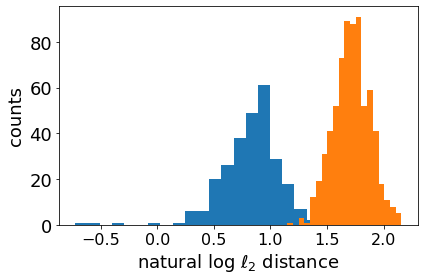

('mnistwo9', 'natural')
0.0


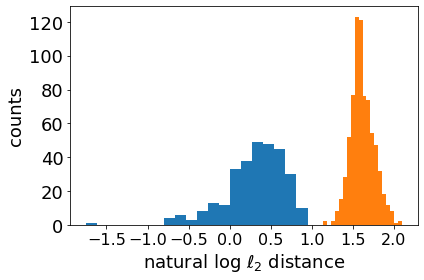

('mnistwo9', 'TRADES(2)')
0.0


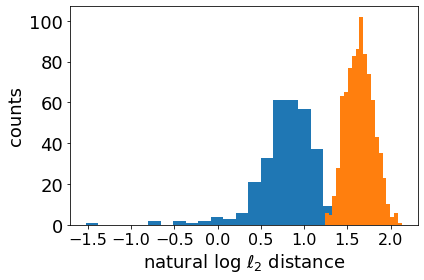

('mnistwo9', 'TRADES(4)')
0.12
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare


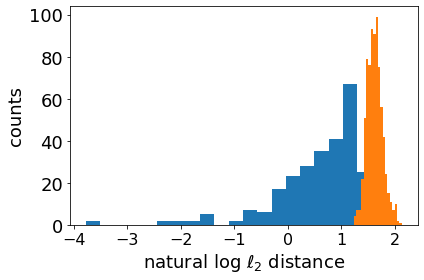

('mnistwo9', 'TRADES(8)')
0.0


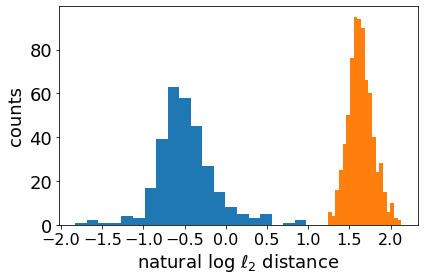

('mnistwo9', 'AT(2)')
0.08666666666666667
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare
Rare


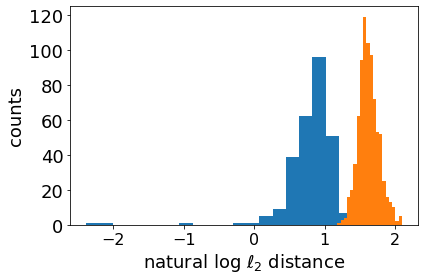

In [22]:
all_settings = []

method_names = [("natural", 'ce', 1.0), ("TRADES(2)", 'trades6ce', 2.0), ("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0), ("AT(2)", 'advce', 2.0)]

#for i in [0, 4, 9]:
#    for method_name, loss, eps in method_names:
#        arch = "WRN_40_10"
#        all_settings.append(
#            dict(
#                dname = f"cifar10wo{i}",
#                dataset = f"cifar10wo{i}",
#                model_path = f"../models/out_of_sample/pgd-64-cifar10wo{i}-70-{eps}-0.01-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0-ep0070.pt",
#                result_path = f"../results/oos_repr/cwl2-64-cifar10wo{i}-70-{eps}-0.01-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
#                ood_result_paths = [
#                    f"../results/ood_robustness_correct/cwl2-64-cifar10wo{i}-70-{eps}-0.01-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
#                ],
#                method_name = method_name,
#                arch = arch,
#            )
#        )
#        
#        
#        all_settings.append(
#            dict(
#                dname = f"cifar100coarsewo{i}",
#                dataset = f"cifar100coarsewo{i}",
#                model_path = f"../models/out_of_sample/pgd-64-cifar100coarsewo{i}-70-{eps}-0.01-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0-ep0070.pt",
#                result_path = f"../results/oos_repr/cwl2-64-cifar100coarsewo{i}-70-{eps}-0.01-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
#                ood_result_paths = [
#                    f"../results/ood_robustness_correct/cwl2-64-cifar100coarsewo{i}-70-{eps}-0.01-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
#                ],
#                method_name = method_name,
#                arch = arch,
#            )
#        )
        
method_names = [("natural", 'ce', 1.0), ("TRADES(2)", 'trades6ce', 2.0), ("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0), ("AT(2)", 'advce', 2.0)]
for i in [0, 1, 2]:
    arch = "ResNet50Norm01"
    for method_name, loss, eps in method_names:
        lr = 0.01
        all_settings.append(
            dict(
                dname = f"aug10-imgnet100wo{i}",
                dataset = f"aug10-imgnet100wo{i}",
                model_path = f"../models/out_of_sample/pgd-128-aug10-imgnet100wo{i}-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0-ep0070.pt",
                result_path = f"../results/oos_repr/cwl2-128-aug10-imgnet100wo{i}-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
                ood_result_paths = [
                    f"../results/ood_robustness_correct/cwl2-128-aug10-imgnet100wo{i}-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
                    f"../results/ood_robustness_correct/fbpgdl2-128-aug10-imgnet100wo{i}-70-{eps}-{lr}-{loss}-vtor2-{arch}-0.0-2-adam-0-0.0.pkl",
                ],
                method_name = method_name,
                arch = arch,
            )
        )
        
method_names = [("natural", 'ce', 1.0), ("TRADES(2)", 'trades6ce', 2.0), ("TRADES(4)", 'trades6ce', 4.0), ("TRADES(8)", 'trades6ce', 8.0), ("AT(2)", 'advce', 2.0)]
for i in [0, 1, 4, 9]:
    for method_name, loss, eps in method_names:
        all_settings.append(
            dict(
                dname = f"mnistwo{i}",
                dataset = f"mnistwo{i}",
                model_path = f"../models/out_of_sample/pgd-128-mnistwo{i}-70-{eps}-0.01-{loss}-vtor2-CNN002-0.9-2-sgd-0-0.0-ep0070.pt",
                result_path = f"../results/oos_repr/cwl2-128-mnistwo{i}-70-{eps}-0.01-{loss}-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl",
                ood_result_paths = [
                    f"../results/ood_robustness_correct/cwl2-128-mnistwo{i}-70-{eps}-0.01-{loss}-vtor2-CNN002-0.9-2-sgd-0-0.0.pkl",
                ],
                method_name = method_name,
                arch = "CNN002",
            )
        )
        
# fraction of time the label goes from cat to dog

for ent in all_settings:
    #dataset, dname, method_name, model_path, result_path, ood_robust_paths, arch = ent['dataset'], ent['dname'], ent['method_name'], ent['model_path'], ent['result_path'], ent['ood_robust_paths'], ent['arch']
    #adv_dists, ood_dists, in_rob_r_portion = get_rob_results(dataset, dname, method_name, model_path, result_path, ood_robust_paths, arch)
    key = (ent['dname'], ent['method_name'])
    print(key)
    if key not in results:
        ent['with_legend'] = False
        adv_dists, ood_dists, in_rob_r_portion, ncg_acc, ood_nn_idx, within_list, ncg_correctness = get_rob_results(**ent)
        results[key] = [np.mean(adv_dists), np.mean(ood_dists), in_rob_r_portion, ncg_acc, ood_nn_idx, within_list, ncg_correctness]

In [23]:
data = {}
for k, v in results.items():
    ood_nn_idx, within_list, ncg_correctness = v[4], v[5], v[6]
    data[k] = [v[0], v[1], v[2], v[3], np.logical_and(within_list, ncg_correctness).mean()]

In [24]:
df = pd.DataFrame.from_dict(data, orient="index",
                            columns=["avg adv dist.", "avg OOD dist.", "XD", "ncg acc", "in radius portion"])
df = df.sort_index()
df.index = pd.MultiIndex.from_tuples(df.index)
df

avg adv dist.  avg OOD dist.        XD  \
aug10-imgnet100wo0  AT(2)           2.766684     155.069113  0.000000   
                    TRADES(2)       3.139885     155.624168  0.000000   
                    TRADES(4)       3.535575     160.046210  0.000000   
                    TRADES(8)       2.674800     161.096930  0.000000   
                    natural         0.292400     157.418586  0.000000   
aug10-imgnet100wo1  AT(2)           2.720583     153.034865  0.000000   
                    TRADES(2)       2.849707     155.914205  0.000000   
                    TRADES(4)       2.919561     156.972648  0.000000   
                    TRADES(8)       2.324356     157.905458  0.000000   
                    natural         0.262179     152.469264  0.000000   
aug10-imgnet100wo2  AT(2)           2.219428     154.279823  0.004474   
                    TRADES(2)       2.488140     155.756040  0.002141   
                    TRADES(4)       2.673374     156.826617  0.004149   
                    TRADES(8)       2.273520     156.272611  0.004246   
                    natural         0.149080     154.157022  0.002045   
calcedrepr-mnistwo4 TRADES(4)      16.436266      54.225028  0.000000   
                    TRADES(8)      20.389073      53.803331  0.000000   
calcedrepr-mnistwo9 TRADES(4)      16.430955      50.695964  0.000000   
                    TRADES(8)      20.465122      51.481997  0.000000   
mnistwo0            AT(2)           2.332245       7.001075  0.000000   
                    TRADES(2)       2.165902       6.976460  0.000000   
                    TRADES(4)       2.072912       6.936148  0.000000   
                    TRADES(8)       0.682265       6.971984  0.000000   
                    natural         1.257136       6.951552  0.000000   
mnistwo1            AT(2)           1.833255       4.299455  0.000000   
                    TRADES(2)       1.566082       4.307595  0.000000   
                    TRADES(4)       1.439671       4.307122  0.000000   
                    TRADES(8)       0.563512       4.287753  0.000000   
                    natural         0.890287       4.327680  0.000000   
mnistwo4            AT(2)           2.339243       5.639562  0.000000   
                    TRADES(2)       2.323594       5.886802  0.000000   
                    TRADES(4)       1.841858       5.654624  0.001242   
                    TRADES(8)       0.657575       5.829020  0.002410   
                    natural         1.330655       5.730208  0.000000   
mnistwo9            AT(2)           2.328356       5.142083  0.000000   
                    TRADES(2)       2.278334       5.246197  0.000000   
                    TRADES(4)       2.181535       5.131419  0.000000   
                    TRADES(8)       0.656668       5.196853  0.000000   
                    natural         1.449574       5.081838  0.000000   

                                ncg acc  in radius portion  
aug10-imgnet100wo0  AT(2)      0.044444           0.000000  
                    TRADES(2)  0.040741           0.000000  
                    TRADES(4)  0.055556           0.000000  
                    TRADES(8)  0.066667           0.000000  
                    natural    0.033333           0.000000  
aug10-imgnet100wo1  AT(2)      0.049630           0.000000  
                    TRADES(2)  0.051852           0.000000  
                    TRADES(4)  0.060741           0.000000  
                    TRADES(8)  0.072593           0.000000  
                    natural    0.047407           0.000000  
aug10-imgnet100wo2  AT(2)      0.026667           0.004474  
                    TRADES(2)  0.030370           0.002141  
                    TRADES(4)  0.043704           0.004149  
                    TRADES(8)  0.047407           0.004246  
                    natural    0.027407           0.002045  
calcedrepr-mnistwo4 TRADES(4)  0.814918           0.000000  
                    TRADES(8)  0.859613           0.000000  
calcedrepr-m

In [25]:
text = df[["avg adv dist.", "avg OOD dist.", "in radius portion", "ncg acc",]].to_latex(float_format="%.2f", multirow=True)
text = text.replace("avg adv dist.", "empirical robust radius")
text = text.replace("avg OOD dist.", "OOD dist.")
text = text.replace("in radius portion", "percentage covered")
text = text.replace("ncg acc", "NCG acc.")
text = text.replace("aug10-imgnet100wo", "I-")
text = text.replace("cifar100coarsewo", "C100-")
text = text.replace("cifar10wo", "C10-")
print(text)

\begin{tabular}{llrrrr}
\toprule
         &         &  empirical robust radius &  OOD dist. &  percentage covered &  NCG acc. \\
\midrule
\multirow{5}{*}{I-0} & AT(2) &           2.77 &         155.07 &               0.00 &     0.04 \\
         & TRADES(2) &           3.14 &         155.62 &               0.00 &     0.04 \\
         & TRADES(4) &           3.54 &         160.05 &               0.00 &     0.06 \\
         & TRADES(8) &           2.67 &         161.10 &               0.00 &     0.07 \\
         & natural &           0.29 &         157.42 &               0.00 &     0.03 \\
\cline{1-6}
\multirow{5}{*}{I-1} & AT(2) &           2.72 &         153.03 &               0.00 &     0.05 \\
         & TRADES(2) &           2.85 &         155.91 &               0.00 &     0.05 \\
         & TRADES(4) &           2.92 &         156.97 &               0.00 &     0.06 \\
         & TRADES(8) &           2.32 &         157.91 &               0.00 &     0.07 \\
         & natural &      